# 1. Hurst & Entropy

In [1]:
import pandas as pd

# Đọc file CSV
df = pd.read_csv("../data/vn30/volume.csv")

In [24]:
import numpy as np
from scipy.stats import entropy
from hurst import compute_Hc
import antropy as ant

# Lấy tất cả các cột chứng khoán (loại trừ cột 'time')
stock_columns = [col for col in df.columns if col != 'time']

# Khởi tạo danh sách lưu kết quả
results = []

# Xử lý từng cột chứng khoán
for stock in stock_columns:
    try:
        # Lấy dữ liệu cho cổ phiếu hiện tại và loại bỏ giá trị NaN
        data = df[stock].dropna().values
        
        if len(data) > 0:
            # Thay thế giá trị 0 bằng một giá trị nhỏ để tránh lỗi log(0)
            data_no_zeros = np.where(data == 0, 1e-10, data)
            
            # Tính chỉ số Hurst
            H, c, data_hurst = compute_Hc(data_no_zeros, kind='price', simplified=True)
            
            # Tính Approximate Entropy (ApEn)
            ApEn = ant.app_entropy(data_no_zeros, order=2)
            
            # Tính Sample Entropy (SampEn)
            SampEn = ant.sample_entropy(data_no_zeros, order=2)
            
            # Tính Permutation Entropy
            PermEn = ant.perm_entropy(data_no_zeros, order=3, normalize=True)
            
            # Lưu kết quả
            results.append({
                "Stock": stock,
                "Hurst Exponent": H,
                "Approximate Entropy": ApEn,
                "Sample Entropy": SampEn,
                "Permutation Entropy": PermEn
            })
        else:
            print(f"Không có dữ liệu hợp lệ cho {stock}")
    except Exception as e:
        print(f"Lỗi khi xử lý {stock}: {e}")

# Chuyển đổi kết quả thành DataFrame để phân tích dễ dàng hơn
results_df = pd.DataFrame(results)

# Sắp xếp theo tên cổ phiếu để dễ đọc
results_df = results_df.sort_values("Stock").reset_index(drop=True)

# Tính toán thống kê để đưa ra insights
stats_df = pd.DataFrame({
    "Mean": results_df.mean(numeric_only=True),
    "Median": results_df.median(numeric_only=True),
    "Min": results_df.min(numeric_only=True),
    "Max": results_df.max(numeric_only=True),
    "Std": results_df.std(numeric_only=True)
}).T

# Hiển thị bảng kết quả
print("Kết quả cho từng cổ phiếu:")
print(results_df.to_string(index=False, float_format=lambda x: f"{x:.4f}"))

print("\nThống kê tổng quan:")
print(stats_df.to_string(float_format=lambda x: f"{x:.4f}"))

# Phân nhóm cổ phiếu theo đặc tính Hurst
hurst_groups = {
    "Random Walk (0.45 < H < 0.55)": results_df[(results_df["Hurst Exponent"] > 0.45) & (results_df["Hurst Exponent"] < 0.55)]["Stock"].tolist(),
    "Anti-persistent (H ≤ 0.45)": results_df[results_df["Hurst Exponent"] <= 0.45]["Stock"].tolist(),
    "Persistent (H ≥ 0.55)": results_df[results_df["Hurst Exponent"] >= 0.55]["Stock"].tolist()
}

print("\nPhân tích dựa trên chỉ số Hurst:")
for category, stocks in hurst_groups.items():
    print(f"{category}: {', '.join(stocks) if stocks else 'Không có'}")

# Xác định cổ phiếu có giá trị entropy cao nhất/thấp nhất
print("\nCổ phiếu có giá trị entropy đặc biệt:")
metrics = ["Approximate Entropy", "Sample Entropy", "Permutation Entropy"]
for metric in metrics:
    highest = results_df.loc[results_df[metric].idxmax()]
    lowest = results_df.loc[results_df[metric].idxmin()]
    print(f"Cao nhất {metric}: {highest['Stock']} ({highest[metric]:.4f})")
    print(f"Thấp nhất {metric}: {lowest['Stock']} ({lowest[metric]:.4f})")

# Phân tích tổng quan thị trường
avg_hurst = stats_df.loc["Mean", "Hurst Exponent"]
print("\nPhân tích tổng quan thị trường:")
if avg_hurst > 0.55:
    print(f"- Thị trường thể hiện xu hướng bền vững (Hurst trung bình = {avg_hurst:.4f}), gợi ý các mẫu có xu hướng")
elif avg_hurst < 0.45:
    print(f"- Thị trường thể hiện xu hướng đảo chiều về giá trị trung bình (Hurst trung bình = {avg_hurst:.4f}), gợi ý các mẫu có tính quay về giá trị trung bình")
else:
    print(f"- Thị trường thể hiện đặc tính đi ngẫu nhiên (Hurst trung bình = {avg_hurst:.4f}), gợi ý định giá hiệu quả")

# Tương quan giữa các chỉ số
correlation = results_df.iloc[:, 1:].corr()
print("\nTương quan giữa các chỉ số:")
print(correlation.to_string(float_format=lambda x: f"{x:.4f}"))

# Phân tích thêm dựa trên các chỉ số entropy
avg_apen = stats_df.loc["Mean", "Approximate Entropy"]
avg_sampen = stats_df.loc["Mean", "Sample Entropy"]
avg_permen = stats_df.loc["Mean", "Permutation Entropy"]

print("\nPhân tích thêm:")
print(f"- Approximate Entropy trung bình: {avg_apen:.4f}")
print(f"- Sample Entropy trung bình: {avg_sampen:.4f}")
print(f"- Permutation Entropy trung bình: {avg_permen:.4f}")
print("- Giá trị entropy cao hơn chỉ ra tính ngẫu nhiên nhiều hơn và khả năng dự đoán thấp hơn")
print("- Giá trị entropy thấp hơn chỉ ra cấu trúc nhiều hơn và khả năng dự đoán cao hơn")

# Xác định các mẫu đáng chú ý hoặc ngoại lệ
outliers = []
for metric in ["Hurst Exponent", "Approximate Entropy", "Sample Entropy", "Permutation Entropy"]:
    mean = stats_df.loc["Mean", metric]
    std = stats_df.loc["Std", metric]
    high_outliers = results_df[results_df[metric] > mean + 2*std]["Stock"].tolist()
    low_outliers = results_df[results_df[metric] < mean - 2*std]["Stock"].tolist()
    
    if high_outliers:
        outliers.append(f"Cao bất thường trong {metric}: {', '.join(high_outliers)}")
    if low_outliers:
        outliers.append(f"Thấp bất thường trong {metric}: {', '.join(low_outliers)}")

if outliers:
    print("\nCác ngoại lệ đáng chú ý (vượt quá 2 độ lệch chuẩn):")
    for outlier in outliers:
        print(f"- {outlier}")

Kết quả cho từng cổ phiếu:
Stock  Hurst Exponent  Approximate Entropy  Sample Entropy  Permutation Entropy
  ACB          0.5779               1.3355          1.1502               0.9984
  BCM          2.3999               0.7482          0.3000               0.9989
  BID          0.7103               1.3289          1.2001               0.9954
  BVH          0.6650               1.3424          1.0356               0.9975
  CTG          0.5807               1.2670          1.0790               0.9950
  FPT          0.6371               1.2496          1.1057               0.9972
  GAS          0.6672               1.3104          1.1309               0.9967
  GVR          0.6400               1.3499          1.1798               0.9985
  HDB          0.6894               1.1710          0.8753               0.9935
  HPG          0.5869               1.5161          1.5732               0.9978
  LPB          1.0846               1.3077          1.0060               0.9947
  MBB        

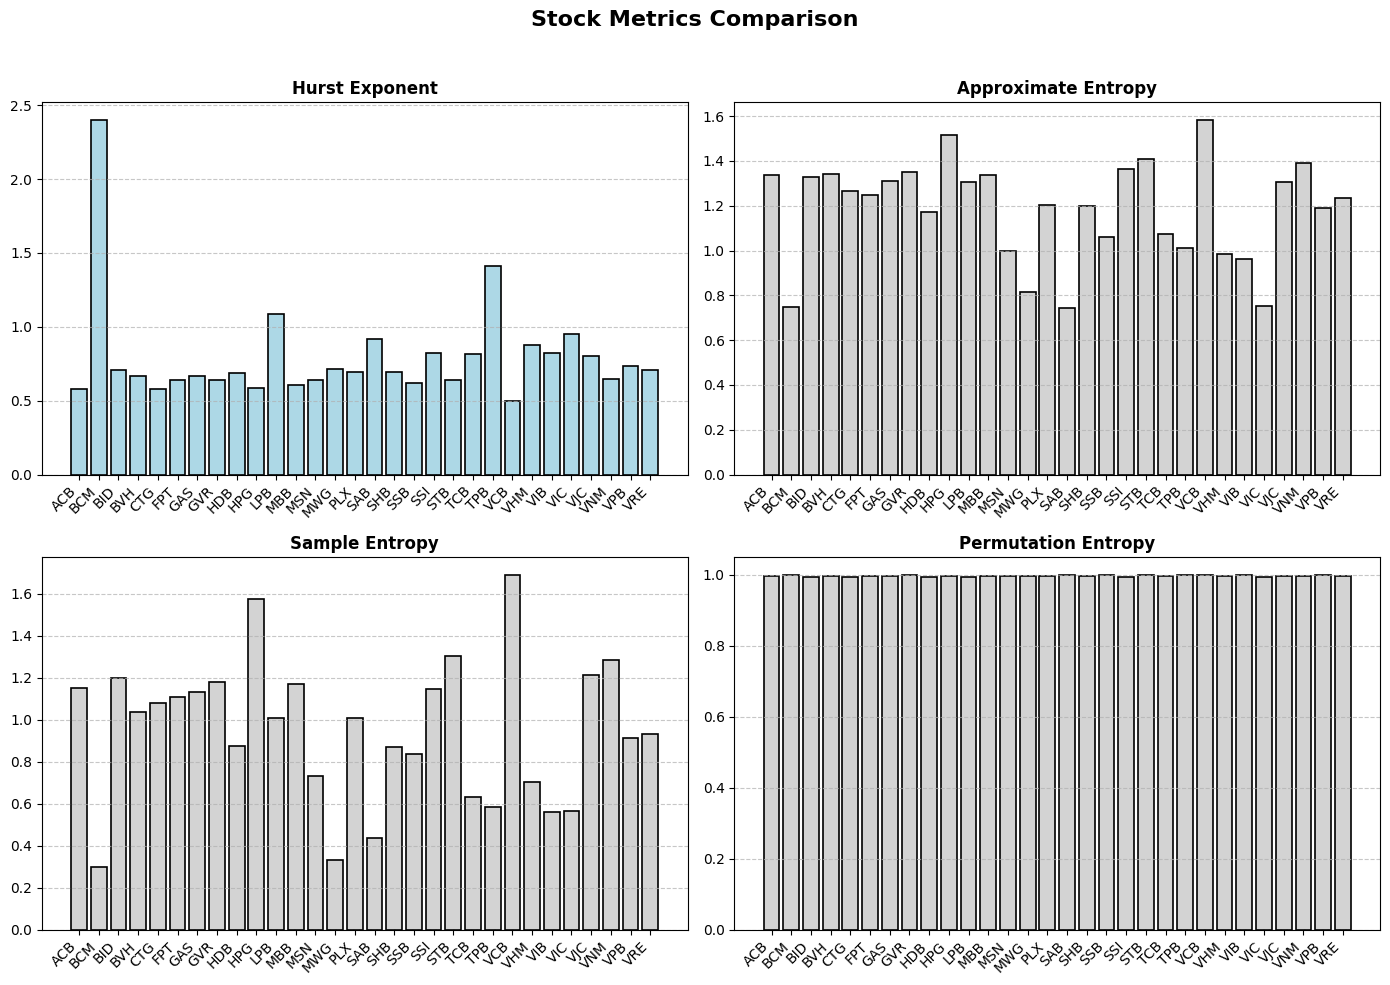

In [25]:
# Tạo lại DataFrame từ dữ liệu cung cấp
import pandas as pd
import matplotlib.pyplot as plt

df_metrics = pd.DataFrame(results_df)

# Vẽ 4 biểu đồ subplot
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
metrics = ["Hurst Exponent", "Approximate Entropy", "Sample Entropy", "Permutation Entropy"]
colors = ["lightblue", "lightgray", "lightgray", "lightgray"]  # Hurst màu xanh nhạt, còn lại xám

# Vẽ từng biểu đồ
for ax, metric, color in zip(axes.flatten(), metrics, colors):
    ax.bar(df_metrics["Stock"], df_metrics[metric], color=color, edgecolor='black', linewidth=1.2)
    ax.set_title(metric, fontsize=12, fontweight="bold")
    ax.set_xticks(range(len(df_metrics["Stock"])))
    ax.set_xticklabels(df_metrics["Stock"], rotation=45, ha="right")
    ax.grid(axis="y", linestyle="--", alpha=0.7)

# Tiêu đề chính cho toàn bộ subplot
fig.suptitle("Stock Metrics Comparison", fontsize=16, fontweight="bold")

# Tăng khoảng cách giữa các subplot
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Hiển thị biểu đồ
plt.show()


In [34]:
import numpy as np
import pandas as pd
from scipy.stats import entropy
import antropy as ant

# Lấy tất cả các cột chứng khoán (loại trừ cột 'time')
stock_columns = [col for col in df.columns if col != 'time']

# Khởi tạo danh sách lưu kết quả
results = []

# Hàm tính Recurrence Rate (RR)
def compute_rr(data, threshold=0.1):
    """Tính tỷ lệ tái phát"""
    data_norm = (data - np.min(data)) / (np.max(data) - np.min(data))
    n = len(data_norm)
    count = 0
    for i in range(n):
        for j in range(i, n):  # Chỉ tính nửa trên của ma trận để tăng tốc
            if abs(data_norm[i] - data_norm[j]) < threshold:
                count += 1
    count = 2 * count - n  # Nhân đôi kết quả trừ đi đường chéo
    return count / (n * n)

# Hàm tính Determinism (DET)
def compute_det(data, threshold=0.1):
    """Tính độ quyết định"""
    n = len(data)
    if n <= 1:
        return 0
    autocorr = np.correlate(data, data, mode='full')[n-1:] / (n * np.var(data))
    det_points = np.sum(autocorr > threshold)
    return det_points / len(autocorr)

# Hàm tính Laminarity (LAM)
def compute_lam(data, threshold=0.1):
    """Tính độ trầm"""
    n = len(data)
    if n <= 1:
        return 0
    changes = np.abs(np.diff(data)) / np.std(data)
    lam_points = np.sum(changes < threshold)
    return lam_points / (n - 1)

# Hàm tính Trapping Time (TT)
def compute_tt(data, threshold=0.1):
    """Tính thời gian bẫy"""
    n = len(data)
    if n <= 1:
        return 0
    changes = np.abs(np.diff(data)) / np.std(data)
    is_trapped = changes < threshold
    
    trapped_segments = []
    current_segment = 0
    for trapped in is_trapped:
        if trapped:
            current_segment += 1
        else:
            if current_segment > 0:
                trapped_segments.append(current_segment)
                current_segment = 0
    if current_segment > 0:
        trapped_segments.append(current_segment)
    
    return np.mean(trapped_segments) if trapped_segments else 0

# Hàm tính Shannon Entropy
def compute_shannon(data, bins=20):
    """Tính Shannon Entropy"""
    hist, _ = np.histogram(data, bins=bins, density=True)
    hist = hist[hist > 0]
    return entropy(hist)

# Hàm tính KS Entropy
def compute_ks_entropy(data):
    """Tính Kolmogorov-Sinai Entropy"""
    try:
        e1 = ant.sample_entropy(data, order=2)
        e2 = ant.sample_entropy(data, order=3)
        return max(0, e2 - e1)
    except:
        return np.nan

# Xử lý từng cột chứng khoán
for stock in stock_columns:
    try:
        data = df[stock].dropna().values
        
        if len(data) > 0:
            # Thay thế giá trị 0 bằng một giá trị nhỏ để tránh lỗi log(0)
            data_no_zeros = np.where(data == 0, 1e-10, data)
            
            # Tính các chỉ số
            rr = compute_rr(data_no_zeros)
            det = compute_det(data_no_zeros)
            lam = compute_lam(data_no_zeros)
            tt = compute_tt(data_no_zeros)
            shannon_ent = compute_shannon(data_no_zeros)
            ks_ent = compute_ks_entropy(data_no_zeros)
            
            # Lưu kết quả
            results.append({
                "Stock": stock,
                "Recurrence Rate (RR)": rr,
                "Determinism (DET)": det,
                "Laminarity (LAM)": lam,
                "Trapping Time (TT)": tt,
                "Shannon Entropy": shannon_ent,
                "KS Entropy": ks_ent
            })
        else:
            print(f"Không có dữ liệu hợp lệ cho {stock}")
    except Exception as e:
        print(f"Lỗi khi xử lý {stock}: {e}")

# Tạo DataFrame kết quả và sắp xếp
results_df = pd.DataFrame(results)
results_df = results_df.sort_values("Stock").reset_index(drop=True)

# Tính các thống kê cơ bản
stats_df = pd.DataFrame({
    "Mean": results_df.mean(numeric_only=True),
    "Median": results_df.median(numeric_only=True),
    "Min": results_df.min(numeric_only=True),
    "Max": results_df.max(numeric_only=True),
    "Std": results_df.std(numeric_only=True)
}).T

# Hiển thị bảng kết quả
print("Kết quả các chỉ số theo cổ phiếu:")
print(results_df.to_string(index=False, float_format=lambda x: f"{x:.4f}"))

print("\nThống kê tổng quan:")
print(stats_df.to_string(float_format=lambda x: f"{x:.4f}"))

Kết quả các chỉ số theo cổ phiếu:
Stock  Recurrence Rate (RR)  Determinism (DET)  Laminarity (LAM)  Trapping Time (TT)  Shannon Entropy  KS Entropy
  ACB                0.5016             0.9277            0.1793              1.3938           2.1692      0.0000
  BCM                0.5565             0.6597            0.4404              3.0559           1.8083      0.0000
  BID                0.6598             0.9352            0.1657              1.4577           1.8414      0.0000
  BVH                0.4813             0.8736            0.1721              1.3961           2.1960      0.0000
  CTG                0.4488             0.9432            0.1777              1.3962           2.2961      0.0000
  FPT                0.5723             0.9584            0.1825              1.4340           2.0253      0.0000
  GAS                0.5254             0.9192            0.1801              1.3720           2.1241      0.0000
  GVR                0.4852             0.8810        

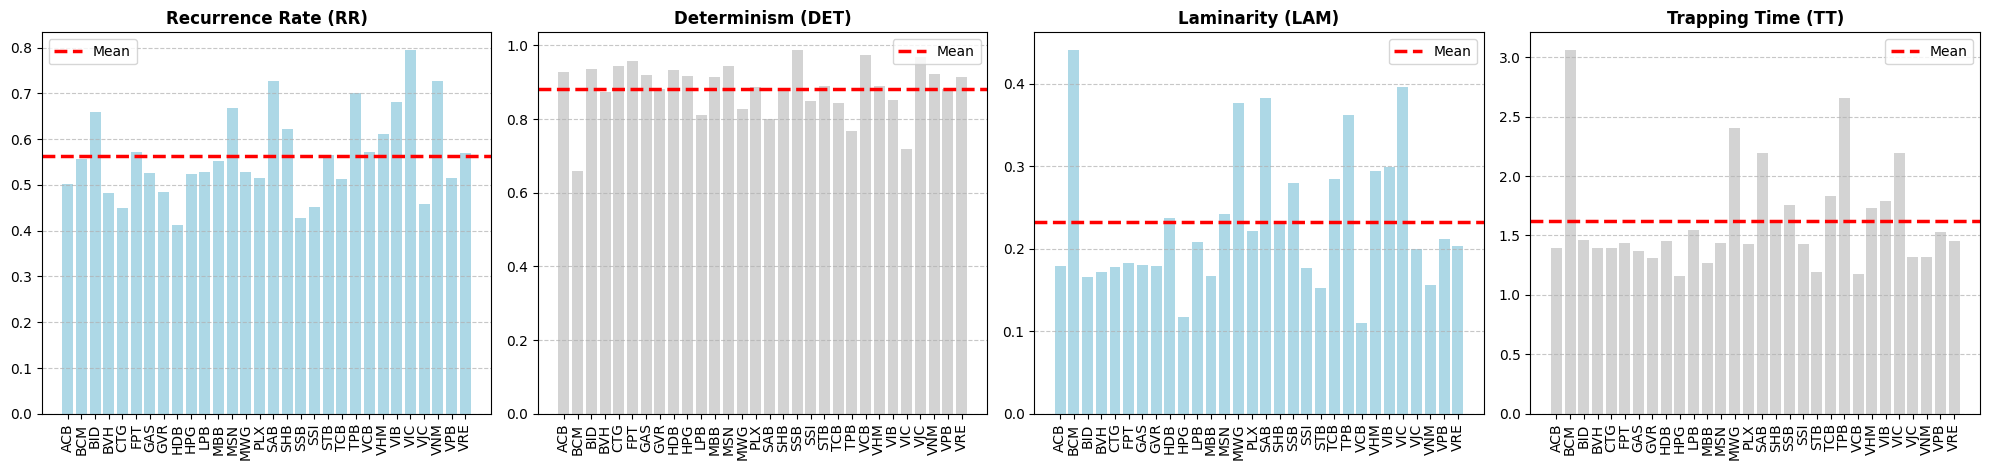

In [40]:
# Tạo lại DataFrame từ dữ liệu cung cấp
df_metrics = results_df[["Stock", "Recurrence Rate (RR)", "Determinism (DET)", "Laminarity (LAM)", "Trapping Time (TT)"]]

# Tính giá trị trung bình cho từng chỉ số
mean_values = df_metrics.mean(numeric_only=True)

# Vẽ 4 biểu đồ subplot trên cùng một hàng
fig, axes = plt.subplots(1, 4, figsize=(20, 5), sharey=False)

metrics = ["Recurrence Rate (RR)", "Determinism (DET)", "Laminarity (LAM)", "Trapping Time (TT)"]
colors = ["lightblue", "lightgray", "lightblue", "lightgray"]  # Áp dụng màu sắc yêu cầu

# Vẽ từng biểu đồ
for ax, metric, color in zip(axes, metrics, colors):
    ax.bar(df_metrics["Stock"], df_metrics[metric], color=color, edgecolor='black', linewidth=0)
    ax.axhline(mean_values[metric], color='red', linestyle="--", linewidth=2.5, label="Mean")  # Đường trung bình
    ax.set_title(metric, fontsize=12, fontweight="bold")
    ax.set_xticks(range(len(df_metrics["Stock"])))
    ax.set_xticklabels(df_metrics["Stock"], rotation=90, ha="center")
    ax.grid(axis="y", linestyle="--", alpha=0.7)
    ax.legend()

# Tăng khoảng cách giữa các subplot
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Hiển thị biểu đồ
plt.show()

In [41]:
import pandas as pd
import numpy as np
from scipy import stats

# Đọc dữ liệu từ file CSV
high_df = pd.read_csv('../data/2024/high.csv')
low_df = pd.read_csv('../data/2024/low.csv')

# Lấy danh sách các công ty (tất cả các cột trừ cột 'time')
companies = [col for col in high_df.columns if col != 'time']

# Khởi tạo dictionary để lưu kết quả
results = {'company': companies}
weekly_irvs = []
monthly_irvs = []
rcis = []
srs = []
krs = []

# Xử lý từng công ty
for company in companies:
    # Tính Chỉ số Dao Động Nội Ngày (IR): giá cao - giá thấp
    IR = high_df[company] - low_df[company]
    
    # Tính Chỉ số Dao Động Nội Ngày Chuẩn Hóa (NIR): IR / (giá cao + giá thấp)
    NIR = IR / (high_df[company] + low_df[company])
    
    # Chuyển đổi thời gian sang định dạng datetime để nhóm
    time_datetime = pd.to_datetime(high_df['time'])
    
    # Tạo DataFrame với thời gian và IR để tính toán
    ir_df = pd.DataFrame({'time': time_datetime, 'IR': IR})
    
    # Thêm cột tuần và tháng
    ir_df['week'] = ir_df['time'].dt.isocalendar().week
    ir_df['year'] = ir_df['time'].dt.year
    ir_df['month'] = ir_df['time'].dt.month
    
    # Tính IRV theo tuần (độ lệch chuẩn của IR theo tuần)
    weekly_groups = ir_df.groupby(['year', 'week'])
    weekly_irv = weekly_groups['IR'].std().mean()
    weekly_irvs.append(weekly_irv)
    
    # Tính IRV theo tháng (độ lệch chuẩn của IR theo tháng)
    monthly_groups = ir_df.groupby(['year', 'month'])
    monthly_irv = monthly_groups['IR'].std().mean()
    monthly_irvs.append(monthly_irv)
    
    # Tính Chỉ số Ổn Định Dao Động (RCI): trung vị IR / trung bình IR
    mean_ir = IR.mean()
    median_ir = IR.median()
    RCI = median_ir / mean_ir if mean_ir != 0 else np.nan
    rcis.append(RCI)
    
    # Tính Chỉ số Độ Méo (SR): độ méo của phân bố IR
    SR = stats.skew(IR.dropna())
    srs.append(SR)
    
    # Tính Chỉ số Nhọn (KR): độ nhọn của phân bố IR
    KR = stats.kurtosis(IR.dropna())
    krs.append(KR)

# Thêm tất cả các chỉ số vào kết quả
results['Weekly_IRV'] = weekly_irvs
results['Monthly_IRV'] = monthly_irvs
results['RCI'] = rcis
results['SR'] = srs
results['KR'] = krs

# Tạo DataFrame từ kết quả
results_df = pd.DataFrame(results)

# Lưu vào file CSV
results_df.to_csv('stock_metrics.csv', index=False)

Đã tạo các biểu đồ trực quan hóa!


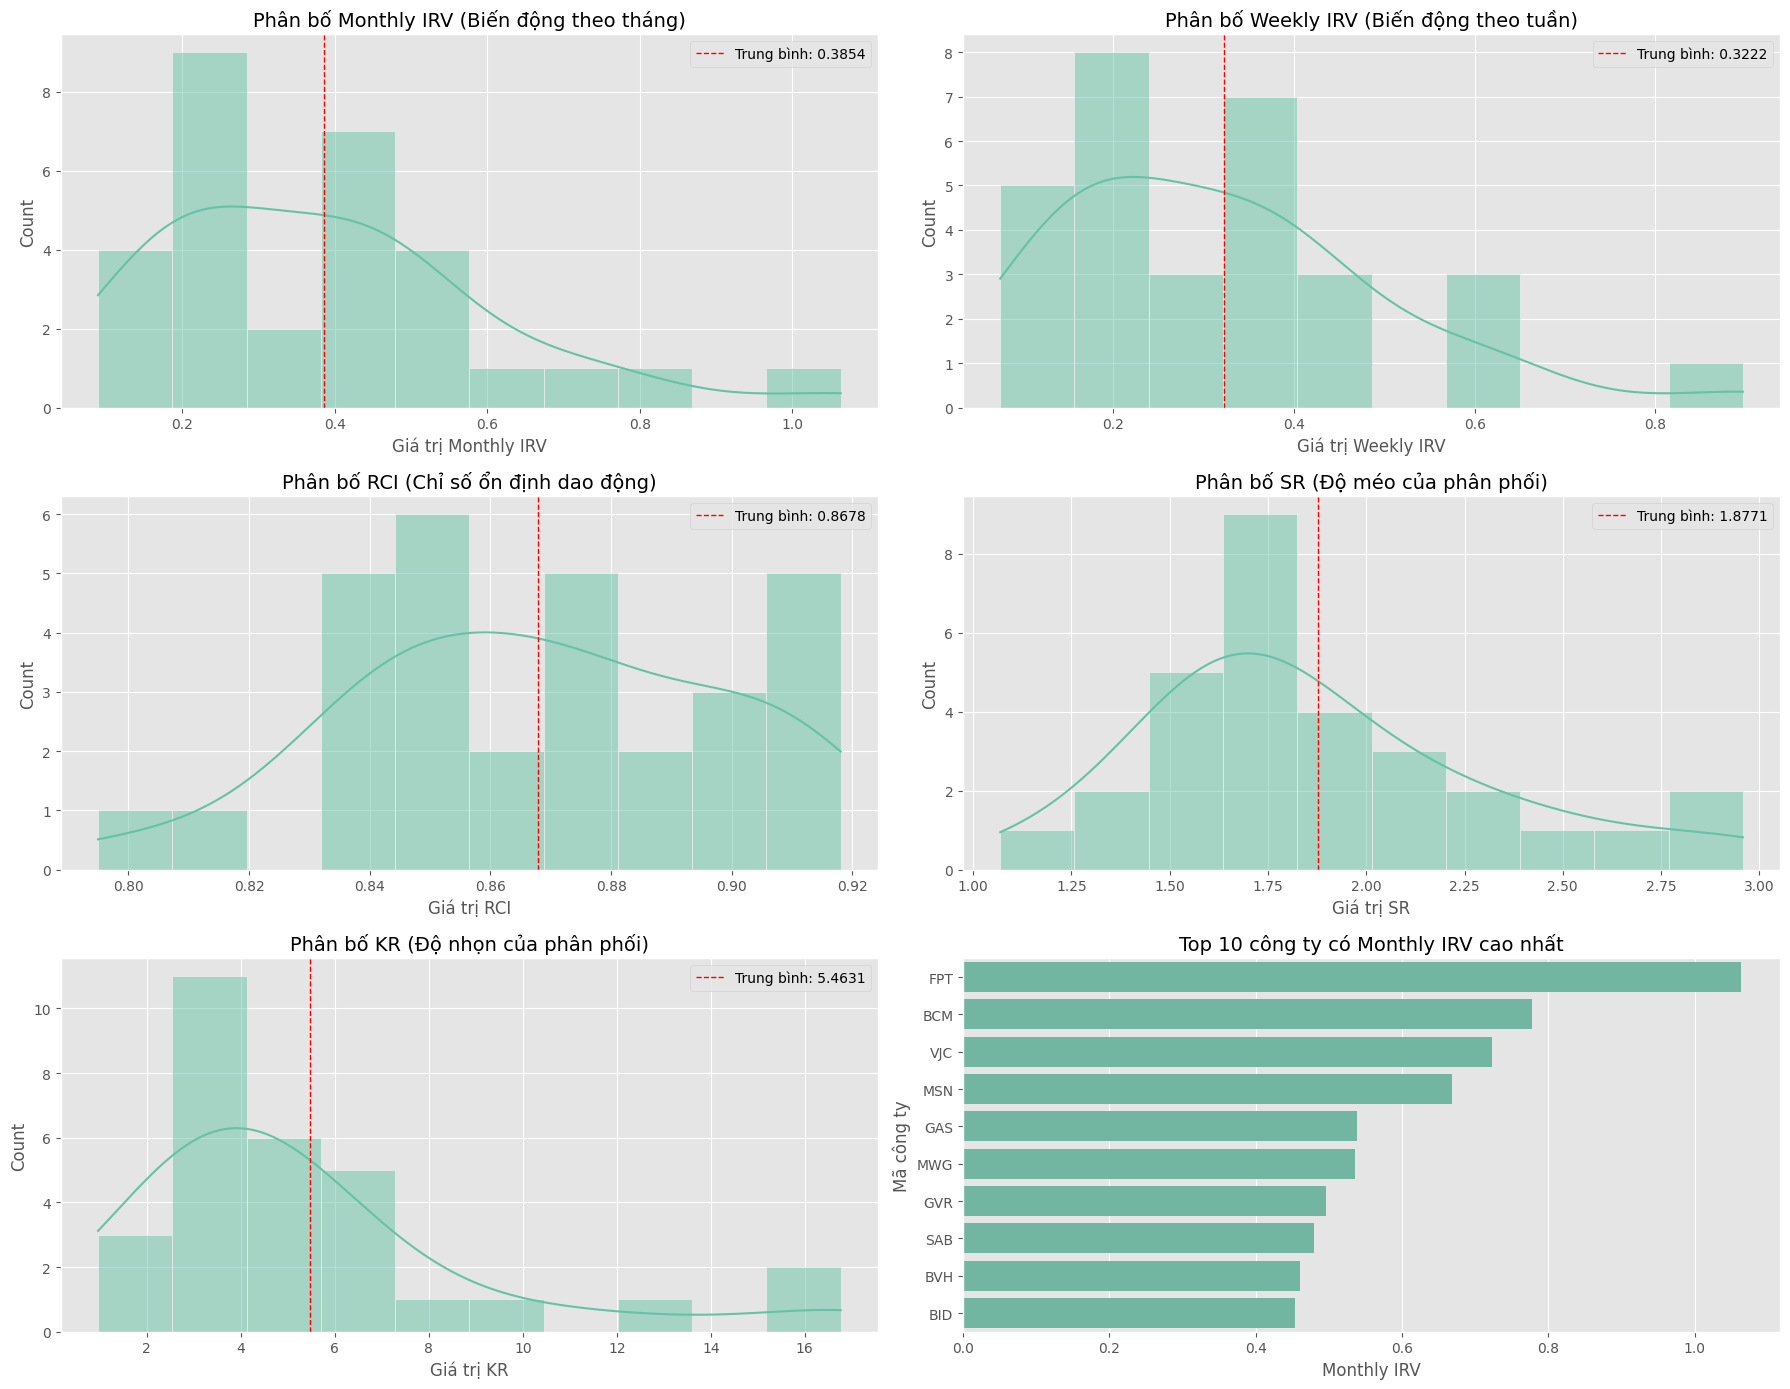

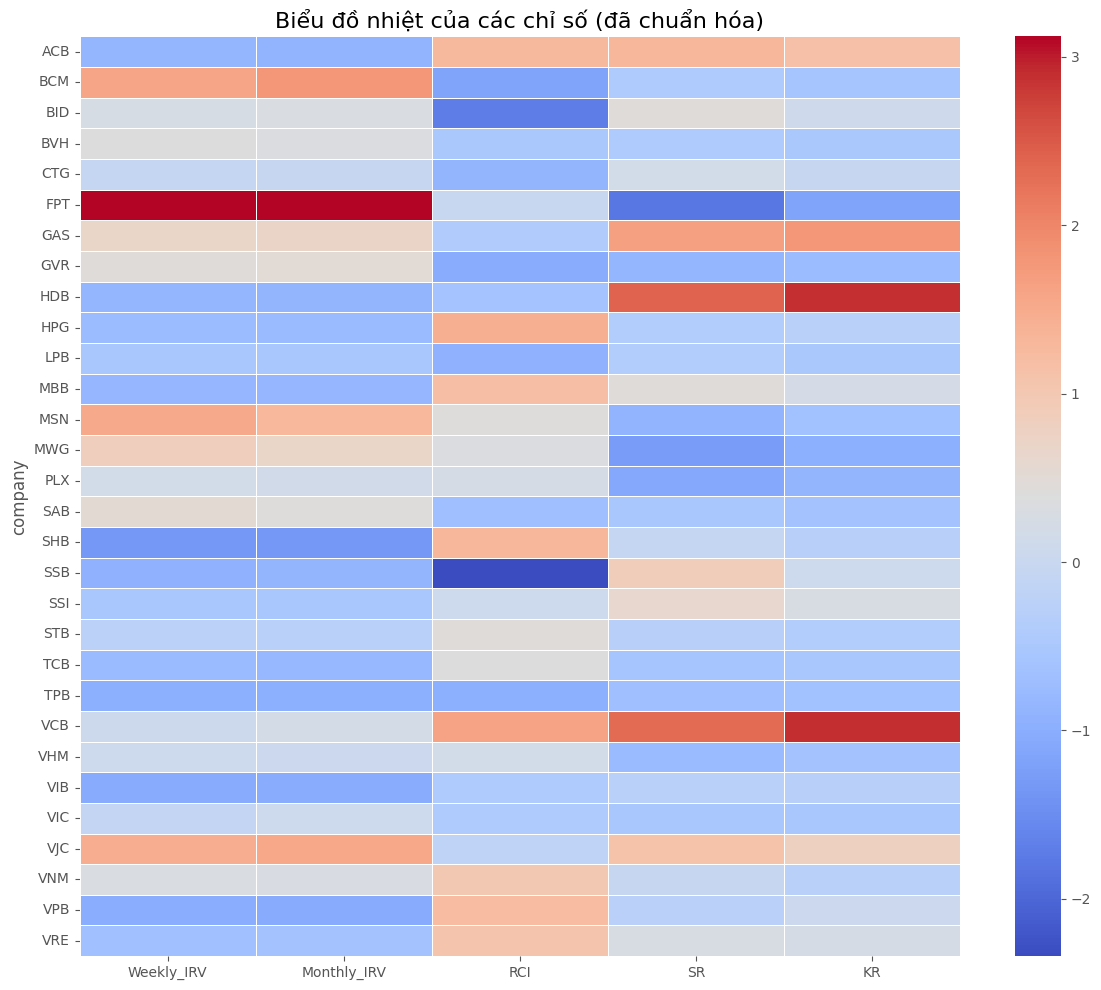

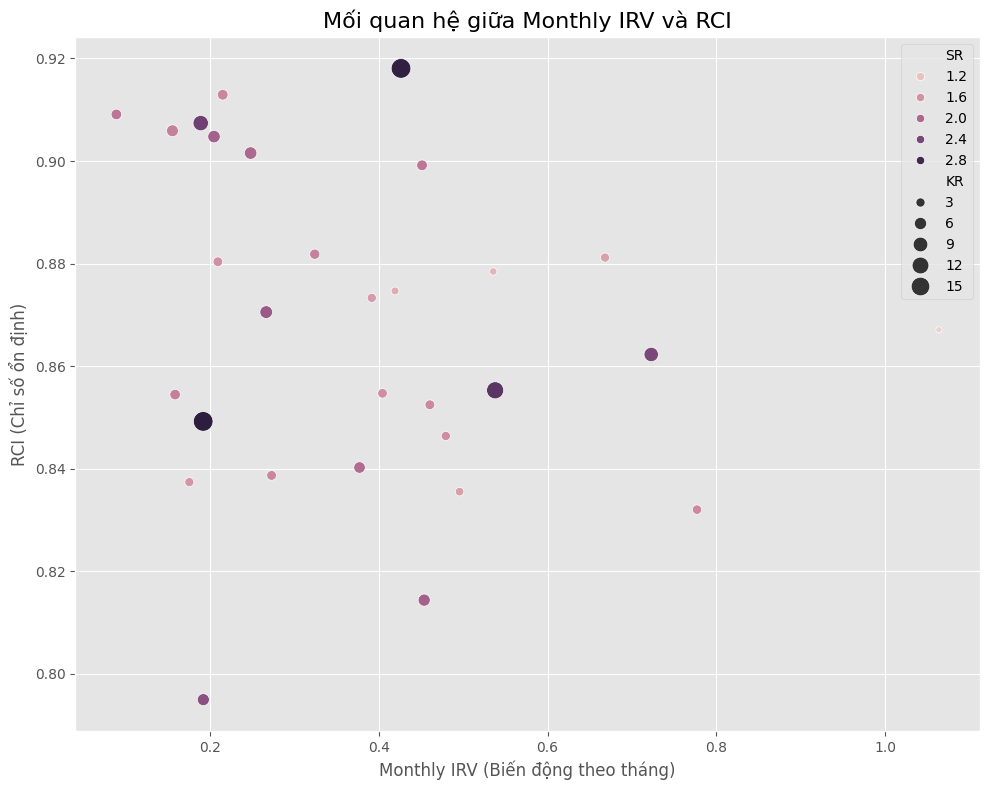

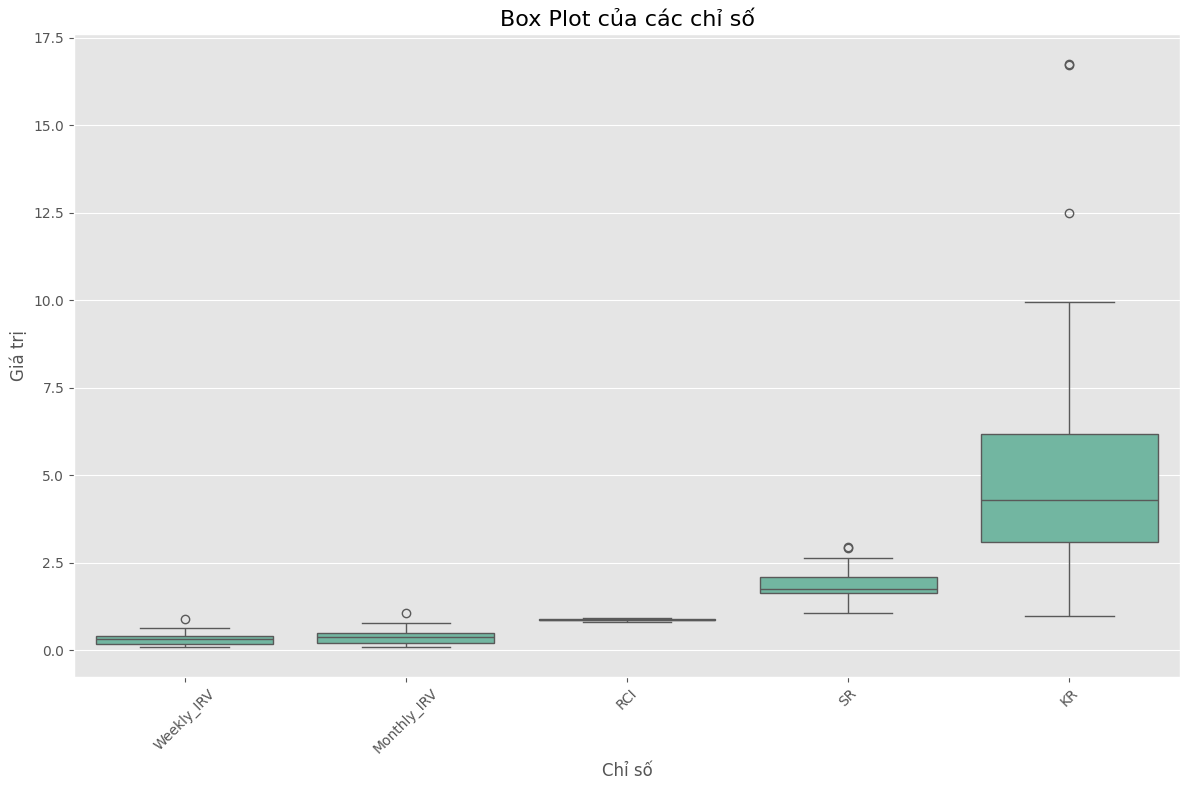

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec

# Đọc dữ liệu từ file đã tạo
df = pd.read_csv('stock_metrics.csv')

# Thiết lập style cho biểu đồ
plt.style.use('ggplot')
sns.set_palette("Set2")

# 1. HISTOGRAM CHO CÁC CHỈ SỐ CHÍNH

# Tạo một figure với 6 subplots cho từng chỉ số
fig = plt.figure(figsize=(18, 14))
gs = GridSpec(3, 2, figure=fig)

# 1.1 Monthly IRV (Biến động theo tháng - chỉ số quan trọng nhất)
ax1 = fig.add_subplot(gs[0, 0])
sns.histplot(df['Monthly_IRV'], bins=10, kde=True, ax=ax1)
ax1.set_title('Phân bố Monthly IRV (Biến động theo tháng)', fontsize=14)
ax1.set_xlabel('Giá trị Monthly IRV')
ax1.axvline(df['Monthly_IRV'].mean(), color='red', linestyle='dashed', linewidth=1, label=f'Trung bình: {df["Monthly_IRV"].mean():.4f}')
ax1.legend()

# 1.2 Weekly IRV
ax2 = fig.add_subplot(gs[0, 1])
sns.histplot(df['Weekly_IRV'], bins=10, kde=True, ax=ax2)
ax2.set_title('Phân bố Weekly IRV (Biến động theo tuần)', fontsize=14)
ax2.set_xlabel('Giá trị Weekly IRV')
ax2.axvline(df['Weekly_IRV'].mean(), color='red', linestyle='dashed', linewidth=1, label=f'Trung bình: {df["Weekly_IRV"].mean():.4f}')
ax2.legend()

# 1.3 RCI (Chỉ số ổn định)
ax3 = fig.add_subplot(gs[1, 0])
sns.histplot(df['RCI'], bins=10, kde=True, ax=ax3)
ax3.set_title('Phân bố RCI (Chỉ số ổn định dao động)', fontsize=14)
ax3.set_xlabel('Giá trị RCI')
ax3.axvline(df['RCI'].mean(), color='red', linestyle='dashed', linewidth=1, label=f'Trung bình: {df["RCI"].mean():.4f}')
ax3.legend()

# 1.4 SR (Độ méo)
ax4 = fig.add_subplot(gs[1, 1])
sns.histplot(df['SR'], bins=10, kde=True, ax=ax4)
ax4.set_title('Phân bố SR (Độ méo của phân phối)', fontsize=14)
ax4.set_xlabel('Giá trị SR')
ax4.axvline(df['SR'].mean(), color='red', linestyle='dashed', linewidth=1, label=f'Trung bình: {df["SR"].mean():.4f}')
ax4.legend()

# 1.5 KR (Độ nhọn)
ax5 = fig.add_subplot(gs[2, 0])
sns.histplot(df['KR'], bins=10, kde=True, ax=ax5)
ax5.set_title('Phân bố KR (Độ nhọn của phân phối)', fontsize=14)
ax5.set_xlabel('Giá trị KR')
ax5.axvline(df['KR'].mean(), color='red', linestyle='dashed', linewidth=1, label=f'Trung bình: {df["KR"].mean():.4f}')
ax5.legend()

# 2. SO SÁNH TOP CÔNG TY THEO MONTHLY IRV
ax6 = fig.add_subplot(gs[2, 1])
top_monthly_irv = df.sort_values('Monthly_IRV', ascending=False).head(10)
sns.barplot(x='Monthly_IRV', y='company', data=top_monthly_irv, ax=ax6)
ax6.set_title('Top 10 công ty có Monthly IRV cao nhất', fontsize=14)
ax6.set_xlabel('Monthly IRV')
ax6.set_ylabel('Mã công ty')

plt.tight_layout()

# 3. BIỂU ĐỒ NHIỆT (HEATMAP) CHO TẤT CẢ CÁC CHỈ SỐ
plt.figure(figsize=(12, 10))

# Chọn các cột số để trực quan hóa
numeric_cols = ['Weekly_IRV', 'Monthly_IRV', 'RCI', 'SR', 'KR']
data_for_heatmap = df.set_index('company')[numeric_cols]

# Chuẩn hóa dữ liệu để so sánh các chỉ số khác nhau
normalized_data = (data_for_heatmap - data_for_heatmap.mean()) / data_for_heatmap.std()

# Vẽ heatmap
sns.heatmap(normalized_data, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Biểu đồ nhiệt của các chỉ số (đã chuẩn hóa)', fontsize=16)
plt.tight_layout()

# 4. BIỂU ĐỒ PHÂN TÁN (SCATTER PLOT) GIỮA MONTHLY IRV VÀ RCI
plt.figure(figsize=(10, 8))
sns.scatterplot(x='Monthly_IRV', y='RCI', hue='SR', size='KR', sizes=(20, 200), data=df)
plt.title('Mối quan hệ giữa Monthly IRV và RCI', fontsize=16)
plt.xlabel('Monthly IRV (Biến động theo tháng)')
plt.ylabel('RCI (Chỉ số ổn định)')
plt.grid(True)
plt.tight_layout()

# 5. BOX PLOT CHO CÁC CHỈ SỐ CHÍNH
plt.figure(figsize=(12, 8))
# Tạo DataFrame mới với định dạng dài (long format) cho seaborn
long_df = pd.melt(df, id_vars=['company'], value_vars=numeric_cols, 
                  var_name='Metric', value_name='Value')

# Vẽ box plot
sns.boxplot(x='Metric', y='Value', data=long_df)
plt.title('Box Plot của các chỉ số', fontsize=16)
plt.xlabel('Chỉ số')
plt.ylabel('Giá trị')
plt.xticks(rotation=45)
plt.tight_layout()

print("Đã tạo các biểu đồ trực quan hóa!")

Số lượng công ty có đủ dữ liệu: 30 / 30


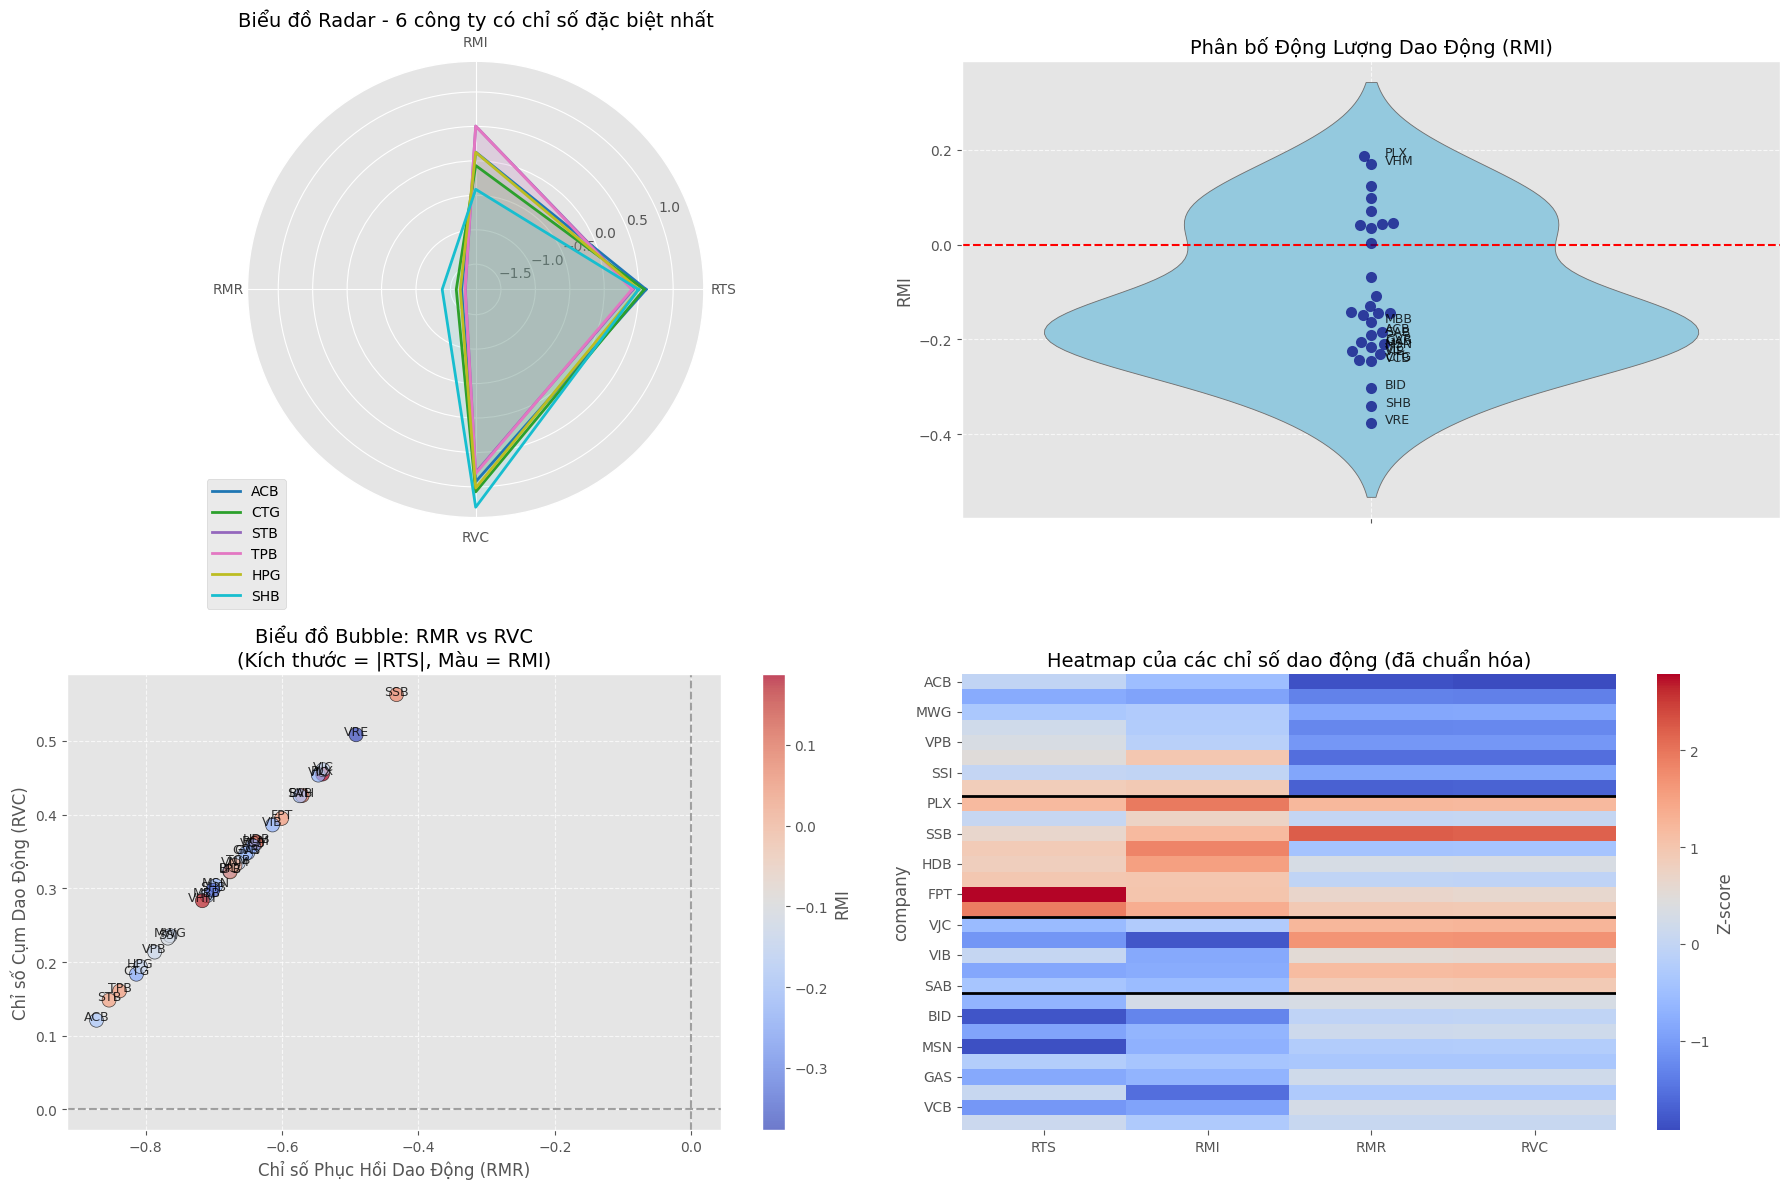

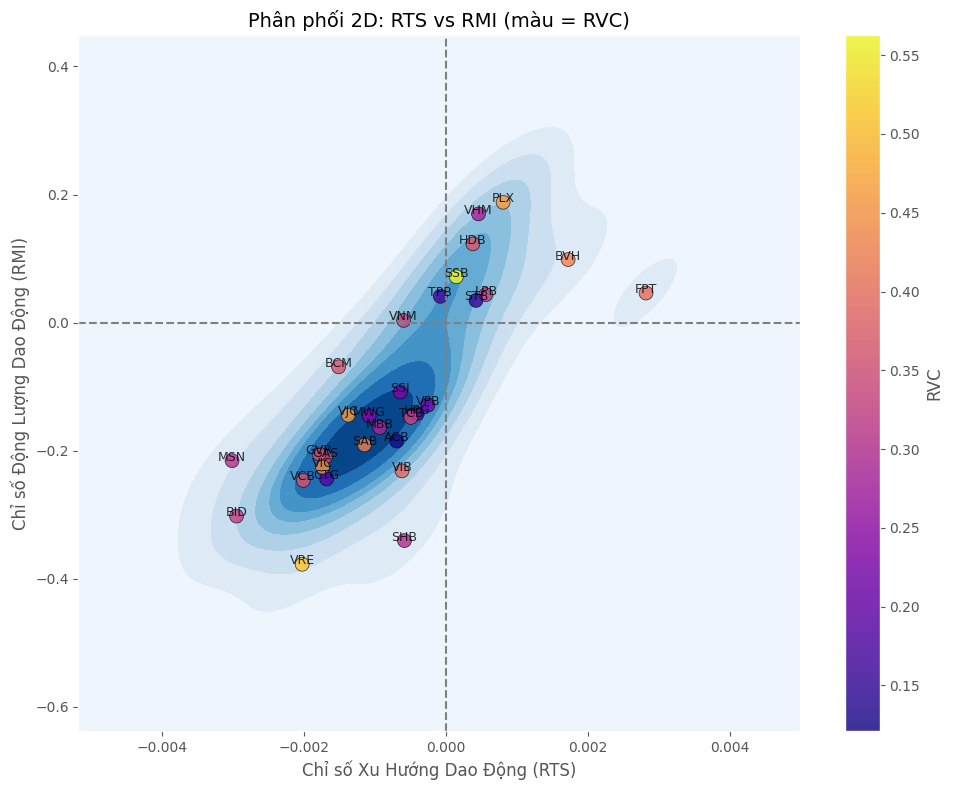


Thống kê các chỉ số:
             RTS        RMI        RMR        RVC
count  30.000000  30.000000  30.000000  30.000000
mean   -0.000664  -0.106833  -0.671644   0.327355
std     0.001272   0.153197   0.109529   0.109169
min    -0.003011  -0.377414  -0.872109   0.120979
25%    -0.001636  -0.214053  -0.752461   0.247607
50%    -0.000628  -0.145070  -0.666646   0.332644
75%     0.000093   0.039436  -0.604086   0.392515
max     0.002822   0.187925  -0.432245   0.562568

Top 5 công ty có RTS cao nhất (xu hướng tăng biến động):
   company       RTS
5      FPT  0.002822
3      BVH  0.001725
14     PLX  0.000808
10     LPB  0.000565
23     VHM  0.000462

Top 5 công ty có RMI cao nhất (động lượng tăng):
   company       RMI
14     PLX  0.187925
23     VHM  0.169783
8      HDB  0.122997
3      BVH  0.098431
17     SSB  0.071611

Top 5 công ty có RMR cao nhất (phục hồi nhanh):
   company       RMR
17     SSB -0.432245
29     VRE -0.491496
26     VJC -0.539873
14     PLX -0.540705
25     VIC -0.

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.tsa.stattools import acf
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.gridspec as gridspec
from matplotlib.colors import Normalize
import warnings
warnings.filterwarnings('ignore')

# Lấy danh sách các công ty (tất cả các cột trừ cột 'time')
companies = [col for col in high_df.columns if col != 'time']

# Chuyển đổi cột time sang định dạng datetime
time_datetime = pd.to_datetime(high_df['time'])

# Khởi tạo dictionary để lưu kết quả
results = {'company': companies}
rts_list = []  # Range Trend Slope
rmi_list = []  # Range Momentum Index
rmr_list = []  # Range Mean Reversion
rvc_list = []  # Range Volatility Clustering

# Xử lý từng công ty
for company in companies:
    # Tính Chỉ số Dao Động Nội Ngày (IR): giá cao - giá thấp
    IR = high_df[company] - low_df[company]
    
    # Tạo DataFrame với thời gian và IR
    ir_df = pd.DataFrame({'time': time_datetime, 'IR': IR})
    
    # Loại bỏ các giá trị NaN
    ir_df_clean = ir_df.dropna(subset=['IR'])
    
    # 1. Chỉ số Xu Hướng Dao Động (RTS)
    # Tạo biến X là số thứ tự ngày (0, 1, 2, ...)
    if len(ir_df_clean) > 1:
        X = np.arange(len(ir_df_clean)).reshape(-1, 1)
        y = ir_df_clean['IR'].values
        
        # Kiểm tra NaN trước khi fit
        if not np.isnan(y).any():
            # Fit mô hình hồi quy tuyến tính
            model = LinearRegression()
            model.fit(X, y)
            
            # Lấy hệ số góc
            RTS = model.coef_[0]
        else:
            RTS = np.nan
    else:
        RTS = np.nan
        
    rts_list.append(RTS)
    
    # 2. Chỉ số Động Lượng Dao Động (RMI)
    # Chia dữ liệu thành nửa đầu và nửa cuối
    if len(ir_df_clean) > 1:
        half_point = len(ir_df_clean) // 2
        first_half = ir_df_clean.iloc[:half_point]
        second_half = ir_df_clean.iloc[half_point:]
        
        # Tính IR trung bình cho từng nửa
        first_half_avg = first_half['IR'].mean()
        second_half_avg = second_half['IR'].mean()
        
        # Tính RMI
        if first_half_avg != 0 and not np.isnan(first_half_avg) and not np.isnan(second_half_avg):
            RMI = second_half_avg / first_half_avg - 1
        else:
            RMI = np.nan
    else:
        RMI = np.nan
        
    rmi_list.append(RMI)
    
    # 3. Chỉ số Phục Hồi Dao Động (RMR)
    # Tạo cột lag 1 để tính sự thay đổi hàng ngày
    ir_df_clean['IR_lag'] = ir_df_clean['IR'].shift(1)
    ir_df_clean['IR_diff'] = ir_df_clean['IR'] - ir_df_clean['IR_lag']
    
    # Lọc lại để loại bỏ NaN từ phép shift
    ir_df_clean = ir_df_clean.dropna(subset=['IR_diff', 'IR'])
    
    # Tính hệ số hồi quy giữa IR và IR_diff (hệ số phục hồi)
    if len(ir_df_clean) > 1:
        X = ir_df_clean['IR'].values.reshape(-1, 1)
        y = ir_df_clean['IR_diff'].values
        
        # Kiểm tra NaN trước khi fit
        if not np.isnan(X).any() and not np.isnan(y).any():
            model = LinearRegression()
            model.fit(X, y)
            RMR = -model.coef_[0]  # Lấy hệ số âm để phản ánh mức độ hồi về trung bình
        else:
            RMR = np.nan
    else:
        RMR = np.nan
    
    rmr_list.append(RMR)
    
    # 4. Chỉ số Cụm Dao Động (RVC)
    # Tính hệ số tự tương quan bậc 1
    if len(ir_df_clean) > 1:
        try:
            ir_autocorr = acf(ir_df_clean['IR'], nlags=1)[1]  # Lấy giá trị tự tương quan bậc 1
        except:
            ir_autocorr = np.nan
    else:
        ir_autocorr = np.nan
    
    rvc_list.append(ir_autocorr)

# Thêm các chỉ số vào kết quả
results['RTS'] = rts_list
results['RMI'] = rmi_list
results['RMR'] = rmr_list
results['RVC'] = rvc_list

# Tạo DataFrame từ kết quả
results_df = pd.DataFrame(results)

# Loại bỏ các hàng có giá trị NaN
results_df = results_df.dropna()

# In thông tin về số lượng công ty còn lại sau khi loại bỏ NaN
print(f"Số lượng công ty có đủ dữ liệu: {len(results_df)} / {len(companies)}")

# Trực quan hóa kết quả bằng các loại biểu đồ mới
plt.figure(figsize=(18, 12))
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1])

# 1. Biểu đồ Radar cho các công ty có giá trị đặc biệt
ax1 = plt.subplot(gs[0, 0], polar=True)

# Chọn 6 công ty có tổng bình phương 4 chỉ số cao nhất
results_df['sum_squared'] = (results_df['RTS']**2 + results_df['RMI']**2 + 
                            results_df['RMR']**2 + results_df['RVC']**2)
top_companies = results_df.sort_values('sum_squared', ascending=False).head(6)

# Chuẩn hóa dữ liệu để vẽ radar chart
categories = ['RTS', 'RMI', 'RMR', 'RVC']
N = len(categories)

# Góc cho mỗi trục
angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]  # Đóng vòng tròn

# Vẽ biểu đồ radar cho từng công ty
colors = plt.cm.tab10(np.linspace(0, 1, len(top_companies)))
for i, (idx, row) in enumerate(top_companies.iterrows()):
    values = [row['RTS'], row['RMI'], row['RMR'], row['RVC']]
    
    # Chuẩn hóa giá trị để hiển thị trên biểu đồ radar
    scaler = StandardScaler()
    values_scaled = scaler.fit_transform(np.array(values).reshape(-1, 1)).flatten()
    
    # Đóng vòng tròn
    values_scaled = np.append(values_scaled, values_scaled[0])
    
    # Vẽ biểu đồ
    ax1.plot(angles, values_scaled, linewidth=2, linestyle='solid', label=row['company'], color=colors[i])
    ax1.fill(angles, values_scaled, alpha=0.1, color=colors[i])

# Đặt tên cho các trục
ax1.set_xticks(angles[:-1])
ax1.set_xticklabels(categories)

# Thêm tiêu đề và legend
ax1.set_title('Biểu đồ Radar - 6 công ty có chỉ số đặc biệt nhất', fontsize=14)
ax1.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

# 2. Biểu đồ Violin kết hợp Swarm cho RMI (Động Lượng Dao Động)
ax2 = plt.subplot(gs[0, 1])
sns.violinplot(y=results_df['RMI'], ax=ax2, color="skyblue", inner=None)
sns.swarmplot(y=results_df['RMI'], ax=ax2, color="navy", size=8, alpha=0.7)

# Thêm nhãn công ty cho các điểm đặc biệt
extreme_rmi = results_df[abs(results_df['RMI']) > results_df['RMI'].std()]
for idx, row in extreme_rmi.iterrows():
    ax2.annotate(row['company'], (0, row['RMI']), xytext=(10, 0), 
                textcoords='offset points', fontsize=9, alpha=0.8)

ax2.set_title('Phân bố Động Lượng Dao Động (RMI)', fontsize=14)
ax2.set_ylabel('RMI')
ax2.grid(True, linestyle='--', alpha=0.7)
ax2.axhline(y=0, color='red', linestyle='--')

# 3. Biểu đồ Bubble cho RMR vs RVC với kích thước RTS và màu RMI
ax3 = plt.subplot(gs[1, 0])
scatter = ax3.scatter(results_df['RMR'], results_df['RVC'], 
                     s=abs(results_df['RTS'])*1000 + 100,  # Kích thước dựa trên |RTS|
                     c=results_df['RMI'], cmap='coolwarm', 
                     alpha=0.7, edgecolors='black')

# Thêm nhãn cho các điểm
for idx, row in results_df.iterrows():
    ax3.annotate(row['company'], (row['RMR'], row['RVC']), 
                fontsize=9, alpha=0.8, ha='center')

ax3.set_xlabel('Chỉ số Phục Hồi Dao Động (RMR)')
ax3.set_ylabel('Chỉ số Cụm Dao Động (RVC)')
ax3.set_title('Biểu đồ Bubble: RMR vs RVC\n(Kích thước = |RTS|, Màu = RMI)', fontsize=14)
plt.colorbar(scatter, label='RMI')
ax3.grid(True, linestyle='--', alpha=0.7)
ax3.axhline(y=0, color='gray', linestyle='--', alpha=0.7)
ax3.axvline(x=0, color='gray', linestyle='--', alpha=0.7)

# 4. Biểu đồ Heatmap kết hợp Clustermap
ax4 = plt.subplot(gs[1, 1])

# Chuẩn bị dữ liệu cho phân cụm
features = ['RTS', 'RMI', 'RMR', 'RVC']
X = results_df[features].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Tạo DataFrame mới để vẽ heatmap
heatmap_df = pd.DataFrame(X_scaled, columns=features, index=results_df['company'])

# Phân cụm
n_clusters = min(4, len(heatmap_df))  # Đảm bảo số cụm không vượt quá số công ty
if len(heatmap_df) >= n_clusters:
    try:
        # Phân cụm và sắp xếp lại DataFrame
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        heatmap_df['cluster'] = kmeans.fit_predict(X_scaled)
        
        # Sắp xếp theo cụm để vẽ heatmap
        heatmap_df = heatmap_df.sort_values('cluster')
        
        # Vẽ heatmap
        sns.heatmap(heatmap_df[features], cmap='coolwarm', ax=ax4, 
                   cbar_kws={'label': 'Z-score'})
        
        # Thêm đường phân chia giữa các cụm
        cluster_counts = heatmap_df['cluster'].value_counts().sort_index()
        cluster_edges = np.cumsum(cluster_counts)[:-1]
        for edge in cluster_edges:
            ax4.axhline(y=edge, color='black', linestyle='-', linewidth=2)
    except:
        # Nếu phân cụm gặp lỗi, vẽ heatmap đơn giản
        sns.heatmap(heatmap_df[features], cmap='coolwarm', ax=ax4, 
                   cbar_kws={'label': 'Z-score'})
else:
    # Nếu quá ít công ty, vẽ heatmap đơn giản
    sns.heatmap(heatmap_df[features], cmap='coolwarm', ax=ax4, 
               cbar_kws={'label': 'Z-score'})

ax4.set_title('Heatmap của các chỉ số dao động (đã chuẩn hóa)', fontsize=14)

plt.tight_layout()
plt.show()

# 5. Biểu đồ Phân phối 2D cho RTS và RMI
plt.figure(figsize=(10, 8))
sns.kdeplot(x=results_df['RTS'], y=results_df['RMI'], cmap="Blues", fill=True, thresh=0)
scatter = plt.scatter(results_df['RTS'], results_df['RMI'], 
                     c=results_df['RVC'], cmap='plasma', 
                     s=100, edgecolor='black', alpha=0.8)

# Thêm nhãn cho các điểm
for idx, row in results_df.iterrows():
    plt.annotate(row['company'], (row['RTS'], row['RMI']), 
                fontsize=9, alpha=0.8, ha='center')

plt.xlabel('Chỉ số Xu Hướng Dao Động (RTS)')
plt.ylabel('Chỉ số Động Lượng Dao Động (RMI)')
plt.title('Phân phối 2D: RTS vs RMI (màu = RVC)', fontsize=14)
plt.colorbar(scatter, label='RVC')
plt.grid(True, linestyle='--', alpha=0.3)
plt.axhline(y=0, color='gray', linestyle='--')
plt.axvline(x=0, color='gray', linestyle='--')
plt.tight_layout()
plt.show()

# Lưu kết quả vào file CSV
results_df.to_csv('range_metrics_advanced.csv', index=False)

# In thông tin thống kê cho từng chỉ số
print("\nThống kê các chỉ số:")
print(results_df[features].describe())

# In các công ty với các chỉ số đặc biệt
print("\nTop 5 công ty có RTS cao nhất (xu hướng tăng biến động):")
print(results_df.sort_values('RTS', ascending=False).head(5)[['company', 'RTS']])

print("\nTop 5 công ty có RMI cao nhất (động lượng tăng):")
print(results_df.sort_values('RMI', ascending=False).head(5)[['company', 'RMI']])

print("\nTop 5 công ty có RMR cao nhất (phục hồi nhanh):")
print(results_df.sort_values('RMR', ascending=False).head(5)[['company', 'RMR']])

print("\nTop 5 công ty có RVC cao nhất (cụm biến động):")
print(results_df.sort_values('RVC', ascending=False).head(5)[['company', 'RVC']])